In [1]:
import os, sys
import rasterio
from rasterio.mask import mask
import numpy as np
from matplotlib import pyplot as plt
import glob
from xml.dom import minidom
import fiona
import scipy.misc as misc

%matplotlib inline

In [4]:
from planet_helper_functions import *

In [17]:
# function to return collection dates from Planet MultiSpectral image metadata
def getDates_planet(xml_file):

    xmldoc = minidom.parse(xml_file)
    date_node = xmldoc.getElementsByTagName("eop:acquisitionDate")
    date_str = str(date_node[0].firstChild.nodeValue)
    acq_date_yyyymmdd = date_str.split('T')[0]        
    
    return acq_date_yyyymmdd

# function to return correction coefficients from Planet MultiSpectral image metadata
def getCorrCoefs_planet(xml_file):

    xmldoc = minidom.parse(xml_file)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
            
    return coeffs

# function to extract image patch
def getImagePatch_planet(imfile, poly):
    
    try:
        with rasterio.open(imfile, 'r') as src:
            arr,_ = mask(src, [poly], crop=True)

        if arr.sum() != 0.:
            return arr
        else:
            return 0
        
    except:
        return 0

# function return geometries as geoJSON
def getGeometries_planet(shpfile):
    
    with fiona.open(shpfile, "r") as shapefile:
        geoms = [feature["geometry"] for feature in shapefile]
        
    return geoms


def getMeansBand(arr, nbands):
    
    res=[]
    for i in range(nbands):
        res.append(arr[i,:,:].mean())
    
    return res

def cor_ms(ms_temp, cf_arr):
    # extract the band means per patch
    ms_band1 = [b[0,:,:] for b in ms_temp]
    ms_band2 = [b[1,:,:] for b in ms_temp]
    ms_band3 = [b[2,:,:] for b in ms_temp]
    ms_band4 = [b[3,:,:] for b in ms_temp]
    
    # correct the ms images to TOA reflectance
    ms_band1_cor = [cf[0] * mn for cf,mn in zip(cf_arr, ms_band1)]
    ms_band2_cor = [cf[1] * mn for cf,mn in zip(cf_arr, ms_band2)]
    ms_band3_cor = [cf[2] * mn for cf,mn in zip(cf_arr, ms_band3)]
    ms_band4_cor = [cf[3] * mn for cf,mn in zip(cf_arr, ms_band4)]
    
    res = []
    for i in range(len(ms_band1_cor)):
        res.append(np.rollaxis(np.dstack((ms_band1_cor[i], ms_band2_cor[i], ms_band3_cor[i], ms_band4_cor[i])),2,0))
    
    return res
    
    

# define function which process the planet images within a specified geometry
def meanIntensityOverGeometry_delete(home_dir, poly):
    
    all_ims = glob.glob('{}/*/*.tif'.format(home_dir))
#     all_ms_ims = [im for im in all_ims if "MS.tif" in im] # only want ms tifs associated with SR files
    all_sr_ims = [im for im in all_ims if "SR" in im]
    all_qa = [im for im in all_ims if "DN_UDM" in im]
#     all_xml = glob.glob('{}/*/*.xml'.format(home_dir)) # only want the xmls associated with SR files
    all_xml = [s.replace('MS_SR.tif', 'MS_metadata.xml') for s in all_sr_ims]
    all_ms_ims = [s.replace('MS_SR.tif', 'MS.tif') for s in all_sr_ims]
    
    c = getCorrCoefs_planet(all_xml[0])
    
    ms_patches = [getImagePatch_planet(im, poly) for im in all_ms_ims]
    sr_patches = [getImagePatch_planet(im, poly) for im in all_sr_ims]
    qa_patches = [getImagePatch_planet(im, poly) for im in all_qa]
    coeffs = [getCorrCoefs_planet(xml) for xml in all_xml]
    dates = [getDates_planet(xml) for xml in all_xml]
    
    # extract the mean values per band. however, we may be getting nodata (0) pixels influencing the mean.
    # may need to break this out into separate steps
    xml_inds = [i for i,j in enumerate(sr_patches) if type(j) is np.ma.core.MaskedArray]
    
    # put the correction coefficients into a usable list corresponding to only overlapping images
    cf_arr=[]
    for i in xml_inds:
        cf_arr.append(np.array([coeffs[i][1], coeffs[i][2], coeffs[i][3], coeffs[i][4]]))
    
    # get the relevant patches
    ms_patch_temp = [ms_patches[i] for i in xml_inds]
    ms_temp = [np.ma.masked_equal(arr, 0.0) for arr in ms_patch_temp if type(arr) is np.ma.core.MaskedArray]
    ms_cor = cor_ms(ms_temp, cf_arr) # correct the MS imagery to TOA reflectance
    ms_means = [getMeansBand(arr,4) for arr in ms_cor]
    
    # get the standard deviations and hi's, lo's (NEW)
    ms_stds = [[a.std() for a in arr] for arr in ms_cor]
    ms_hi = [[a.max() for a in arr] for arr in ms_cor]
    ms_low = [[a.min() for a in arr] for arr in ms_cor]

    sr_patch_temp = [sr_patches[i] for i in xml_inds]
    sr_temp = [np.ma.masked_equal(arr, 0.0) for arr in sr_patch_temp if type(arr) is np.ma.core.MaskedArray]
    sr_means = [getMeansBand(arr,4) for arr in sr_temp]
    
    # get the standard deviations and hi's, lo's (NEW)
    sr_stds = [[a.std() for a in arr] for arr in sr_temp]
    sr_hi = [[a.max() for a in arr] for arr in sr_temp]
    sr_low = [[a.min() for a in arr] for arr in sr_temp]
    
    # extract the band means per patch
    ms_band1_means = [b[0] for b in ms_means]
    ms_band2_means = [b[1] for b in ms_means]
    ms_band3_means = [b[2] for b in ms_means]
    ms_band4_means = [b[3] for b in ms_means]

#     print sr_means[0]
    sr_scale = 10000
    sr_band1_means = [b[0]/sr_scale for b in sr_means]
    sr_band2_means = [b[1]/sr_scale for b in sr_means]
    sr_band3_means = [b[2]/sr_scale for b in sr_means]
    sr_band4_means = [b[3]/sr_scale for b in sr_means]
    
    
    # extract the STD, hi, low, per patch (NEW)
    ms_band1_std_cor = [b[0] for b in ms_stds]
    ms_band2_std_cor = [b[1] for b in ms_stds]
    ms_band3_std_cor = [b[2] for b in ms_stds]
    ms_band4_std_cor = [b[3] for b in ms_stds]
    
    sr_band1_std = [b[0] for b in sr_stds]
    sr_band2_std = [b[1] for b in sr_stds]
    sr_band3_std = [b[2] for b in sr_stds]
    sr_band4_std = [b[3] for b in sr_stds]
    
    ms_band1_range_hi = [b[0] for b in ms_hi]
    ms_band2_range_hi = [b[1] for b in ms_hi]
    ms_band3_range_hi = [b[2] for b in ms_hi]
    ms_band4_range_hi = [b[3] for b in ms_hi]
    
    ms_band1_range_low = [b[0] for b in ms_low]
    ms_band2_range_low = [b[1] for b in ms_low]
    ms_band3_range_low = [b[2] for b in ms_low]
    ms_band4_range_low = [b[3] for b in ms_low]
    
    sr_band1_range_hi = [b[0] for b in sr_hi]
    sr_band2_range_hi = [b[1] for b in sr_hi]
    sr_band3_range_hi = [b[2] for b in sr_hi]
    sr_band4_range_hi = [b[3] for b in sr_hi]
    
    sr_band1_range_low = [b[0] for b in sr_low]
    sr_band2_range_low = [b[1] for b in sr_low]
    sr_band3_range_low = [b[2] for b in sr_low]
    sr_band4_range_low = [b[3] for b in sr_low]
    
    
    # put the dates in a usable list corresponding to only overlapping images
    date_arr = [dates[i] for i in xml_inds]

    res = {}
    res['ms_means'] = [ms_band1_means, ms_band2_means, ms_band3_means, ms_band4_means]
    res['sr_means'] = [sr_band1_means, sr_band2_means, sr_band3_means, sr_band4_means]
    res['dates'] = date_arr
    
    # DEFINE THESE (NEW)
    res['ms_std'] = [ms_band1_std_cor, ms_band2_std_cor, ms_band3_std_cor, ms_band4_std_cor]
    res['sr_std'] = [sr_band1_std, sr_band2_std, sr_band3_std, sr_band4_std]
    
    res['sr_range_hi'] = [ms_band1_range_hi, ms_band2_range_hi, ms_band3_range_hi, ms_band4_range_hi ]
    res['sr_range_hi'] = [sr_band1_range_hi, sr_band2_range_hi, sr_band3_range_hi, sr_band4_range_hi ]
    
    return res

def meanIntensityOverGeometry(home_dir, poly):
    
    all_ims = glob.glob('{}/*/*.tif'.format(home_dir))
#     all_ms_ims = [im for im in all_ims if "MS.tif" in im] # only want ms tifs associated with SR files
    all_sr_ims = [im for im in all_ims if "SR" in im]
    all_qa = [im for im in all_ims if "DN_UDM" in im]
#     all_xml = glob.glob('{}/*/*.xml'.format(home_dir)) # only want the xmls associated with SR files
    all_xml = [s.replace('MS_SR.tif', 'MS_metadata.xml') for s in all_sr_ims]
    all_ms_ims = [s.replace('MS_SR.tif', 'MS.tif') for s in all_sr_ims]
    
    #print(all_xml)
    
    c = getCorrCoefs_planet(all_xml[0])
    
    ms_patches = [getImagePatch_planet(im, poly) for im in all_ms_ims]
    sr_patches = [getImagePatch_planet(im, poly) for im in all_sr_ims]
    qa_patches = [getImagePatch_planet(im, poly) for im in all_qa]
    coeffs = [getCorrCoefs_planet(xml) for xml in all_xml]
    dates = [getDates_planet(xml) for xml in all_xml]
    
    #print(dates)
    
    # extract the mean values per band. however, we may be getting nodata (0) pixels influencing the mean.
    # may need to break this out into separate steps
    xml_inds = [i for i,j in enumerate(sr_patches) if type(j) is np.ma.core.MaskedArray]
    xml_inds = [i for i,j in enumerate(sr_patches) if np.sum(j) > 10]
    
    #print(xml_inds)
    
    # put the correction coefficients into a usable list corresponding to only overlapping images
    cf_arr=[]
    for i in xml_inds:
        cf_arr.append(np.array([coeffs[i][1], coeffs[i][2], coeffs[i][3], coeffs[i][4]]))
    
    
    

    ms_patch_temp = [ms_patches[i] for i in xml_inds]
    ms_temp = [np.ma.masked_equal(arr, 0.0) for arr in ms_patch_temp if type(arr) is np.ma.core.MaskedArray]
    ms_temp = [np.ma.masked_equal(arr, 0.0) for arr in ms_patch_temp if np.sum(arr) > 10]
    ms_cor = cor_ms(ms_temp, cf_arr) # correct the MS imagery to TOA reflectance
    ms_means = [getMeansBand(arr,4) for arr in ms_cor]
    #ms_means = [getMeansBand(arr,4) for arr in ms_patches]

    sr_patch_temp = [sr_patches[i] for i in xml_inds]
    sr_temp = [np.ma.masked_equal(arr, 0.0) for arr in sr_patch_temp if type(arr) is np.ma.core.MaskedArray]
    sr_temp = [np.ma.masked_equal(arr, 0.0) for arr in sr_patch_temp if np.sum(arr) > 10]
    sr_means = [getMeansBand(arr,4) for arr in sr_temp]
    #sr_means = [getMeansBand(arr,4) for arr in sr_patches]
    
    # extract the band means per patch
    ms_band1_means = [b[0] for b in ms_means]
    ms_band2_means = [b[1] for b in ms_means]
    ms_band3_means = [b[2] for b in ms_means]
    ms_band4_means = [b[3] for b in ms_means]

#     print sr_means[0]
    sr_scale = 10000
    sr_band1_means = [b[0]/sr_scale for b in sr_means]
    sr_band2_means = [b[1]/sr_scale for b in sr_means]
    sr_band3_means = [b[2]/sr_scale for b in sr_means]
    sr_band4_means = [b[3]/sr_scale for b in sr_means]
    
    # put the dates in a usable list corresponding to only overlapping images
    date_arr = [dates[i] for i in xml_inds]
    
    #print(1)

    res = {}
    res['ms_means'] = [ms_band1_means, ms_band2_means, ms_band3_means, ms_band4_means]
    res['sr_means'] = [sr_band1_means, sr_band2_means, sr_band3_means, sr_band4_means]
    res['dates'] = date_arr
    res['sr_image'] = sr_patches
    res['ms_image'] = ms_patches
    res['qa_image'] = qa_patches
    
#     res['ms_std'] = [ms_band1_std_cor, ms_band2_std_cor, ms_band3_std_cor, ms_band4_std_cor]
#     res['sr_std'] = [sr_band1_std, sr_band2_std, sr_band3_std, sr_band4_std]
    return res

In [18]:
# extract the data. it will be a bunch of lists
home_dir = r"C:\Projects\RD\planet\sample_order"
shp = r"C:\Projects\rd\planet\proj_cc_sites.shp"
polys = getGeometries_planet(shp)

res = [meanIntensityOverGeometry(home_dir, poly) for poly in polys]

In [16]:
print(res[0].keys())

['dates', 'qa_image', 'ms_image', 'ms_means', 'sr_means', 'sr_image']


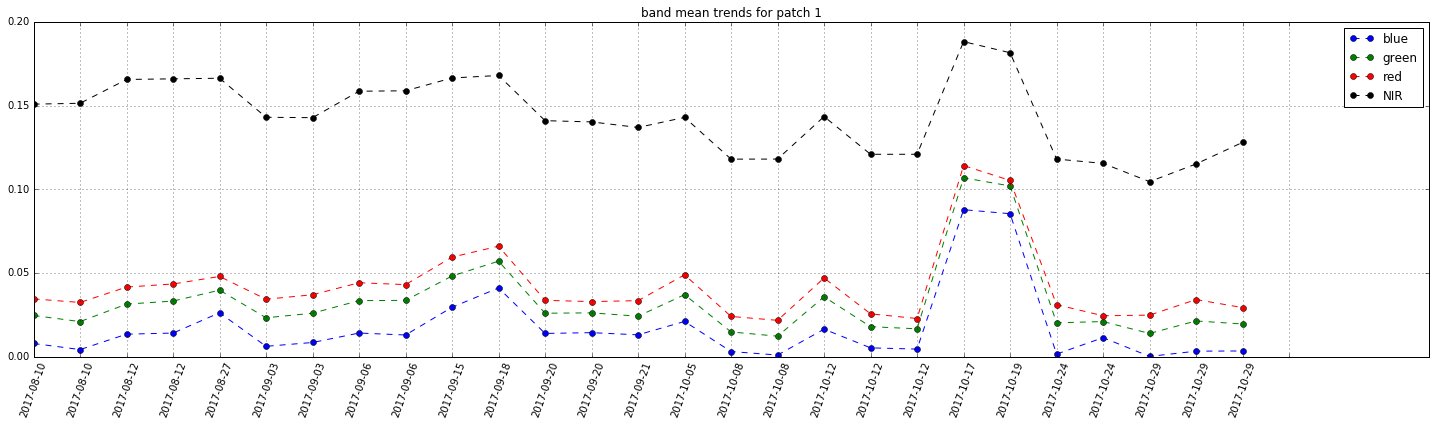

In [15]:
# do a test plot
idx = 1
bands=['blue', 'green', 'red', 'NIR']
colors = ['b', 'g', 'r', 'k']
plt.figure(figsize=(25,6))
for i in range(4):
    
    plt.plot(res[idx]['sr_means'][i], color=colors[i], label=bands[i], linestyle='--', marker='o')
    plt.title('band mean trends for patch {}'.format(idx))
    
plt.legend()
ax = plt.gca()
xmarks = range(0, len(res[idx]['dates'])+1, 1)
plt.xticks(xmarks)

ax.set_xticklabels(res[idx]['dates'])
plt.xticks(rotation=70)
ax.grid()
plt.show()

In [ ]:
# check the NDVI trend for one of the patches
temp=(np.array(res[idx]['ms_means'][3]) - np.array(res[idx]['ms_means'][2])) / (np.array(res[idx]['ms_means'][3]) + np.array(res[idx]['ms_means'][2]))
plt.title('NDVI trend for patch {}'.format(idx))
plt.plot(temp, label='MS TOA', linestyle='--', marker='o')
temp1=(np.array(res[idx]['sr_means'][3]) - np.array(res[idx]['sr_means'][2])) / (np.array(res[idx]['sr_means'][3]) + np.array(res[idx]['sr_means'][2]))
plt.plot(temp1, 'r', label='SR', linestyle='--', marker='o')
plt.legend()

In [ ]:
plt.plot(np.array(temp1)-np.array(temp))
plt.title('difference in NDVI for SR-MS')

In [ ]:
%matplotlib inline
def save_plot_means(p, fi, plot_num, dates, proc):
    bands=['blue', 'green', 'red', 'NIR']
    colors = ['b', 'g', 'r', 'k']
    plt.figure(figsize=(25,6))
    for i in range(4):

        plt.plot(p[i], color=colors[i], label=bands[i], linestyle='--', marker='o')
        plt.title('{} band mean trends for patch {}'.format(proc, plot_num+1))

    plt.legend()
    ax = plt.gca()
    
    # label ticks
    xmarks = range(0, len(dates)+1, 1)
    plt.xticks(xmarks)
    ax.set_xticklabels(dates)
    
    # label y axis
    if proc=='MS':
        plt.ylabel('Reflectance (TOA)')
    else:
        plt.ylabel('Reflectance (SR)')

    
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-0.05,0.5))
    
    plt.xticks(rotation=70)
    ax.grid()
    plt.tight_layout()
    
    plt.savefig(fi)
    
    return
    

# save all figures for each patch
for i,patch in enumerate(res):
    
    plot_dir = r'C:\Projects\RD\planet\figs'
    sr_plot_name = 'sr_planet_plot_{}.png'.format(i+1)
    sr_fi = os.path.join(plot_dir, sr_plot_name)
    ms_plot_name = 'ms_planet_plot_{}'.format(i+1)
    ms_fi = os.path.join(plot_dir, ms_plot_name)
    
#     print sr_plot_name
    
    save_plot_means(patch['sr_means'], sr_fi, i, patch['dates'], proc='SR')
    save_plot_means(patch['ms_means'], ms_fi, i, patch['dates'], proc='MS')
    

In [ ]:
print(res[idx]['dates'])

In [ ]:
from datetime import datetime
imtime = str(res[idx]['dates'][0])
print(imtime)
datetime.strptime(imtime, '%Y-%m-%d')

In [ ]:
test = '2017-10-12T17:54:08+00:00'
part1 = test.split('T')[0]
part2 = test.split('T')[1].split('+')[0]
print(part1, part2)

In [ ]:
test_rfm = ' '.join([i for i in [part1,part2]])
print(test_rfm)

In [ ]:
datetime.strptime(test_rfm, '%Y-%m-%d %H:%M:%S')

### this plotting cell uses only the dates which are relevant to the first buffer size

**************************************************************************
****************** PLOT 0 ***********************************************
**************************************************************************


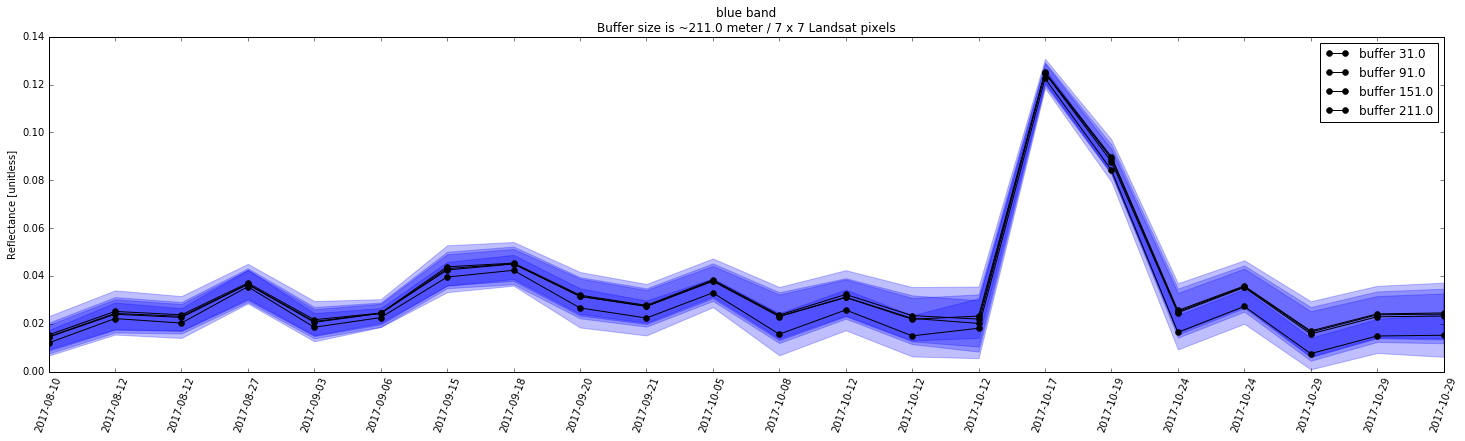

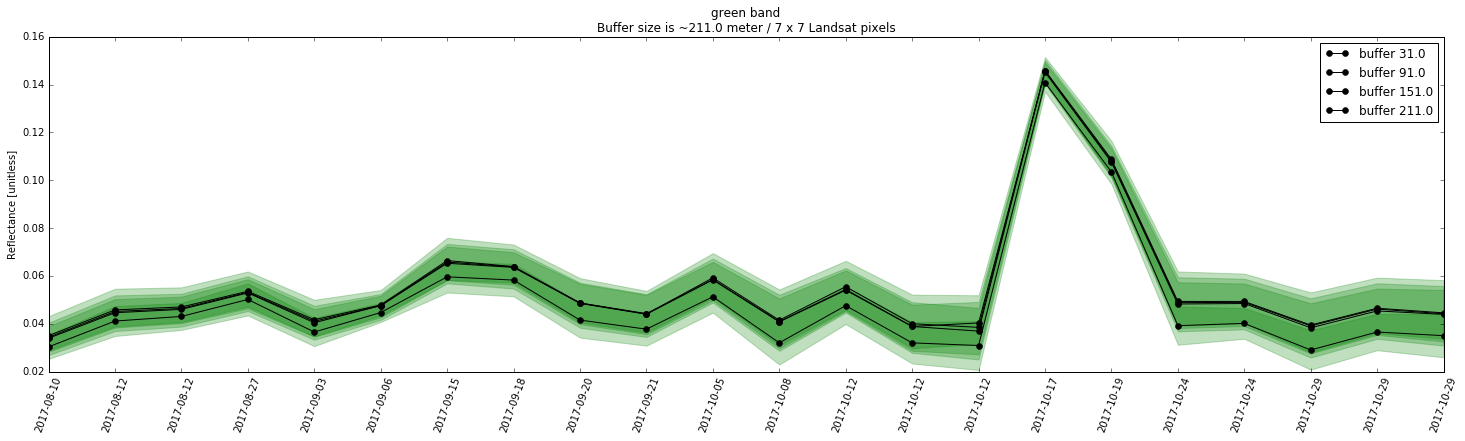

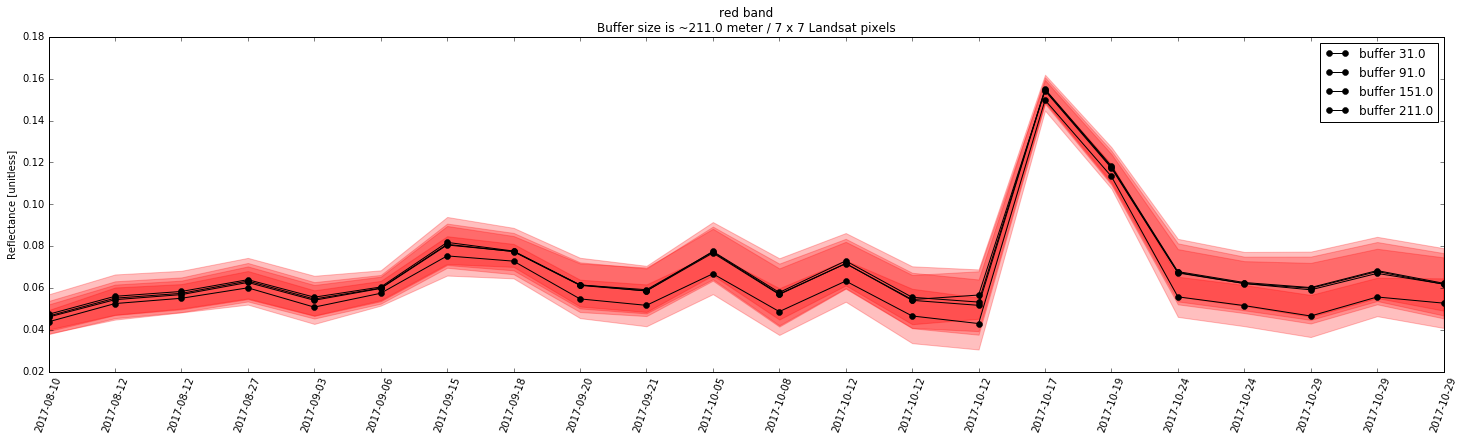

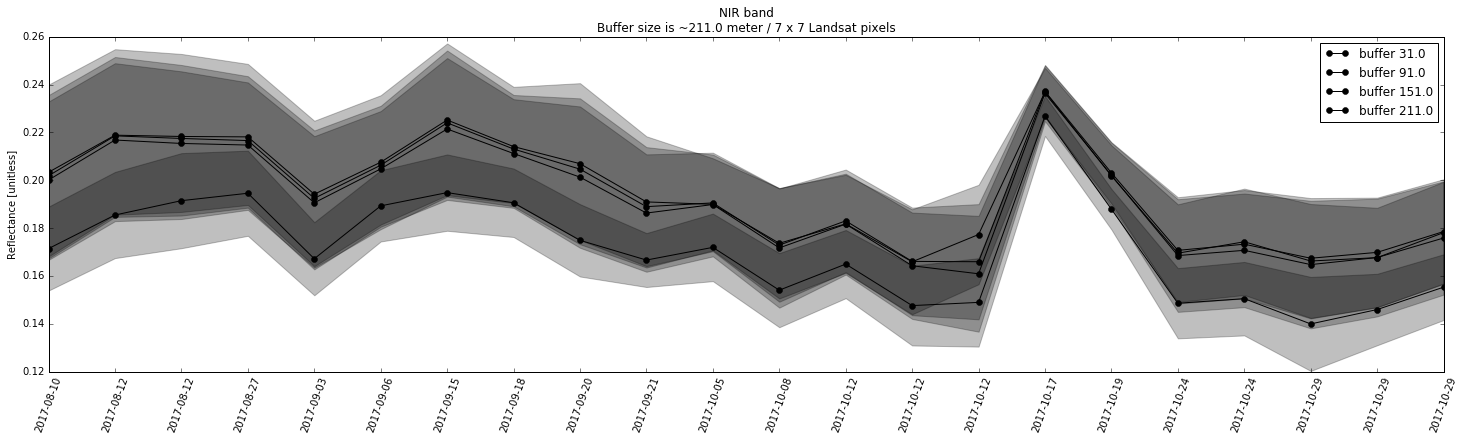

**************************************************************************
**************************************************************************
****************** PLOT 1 ***********************************************
**************************************************************************


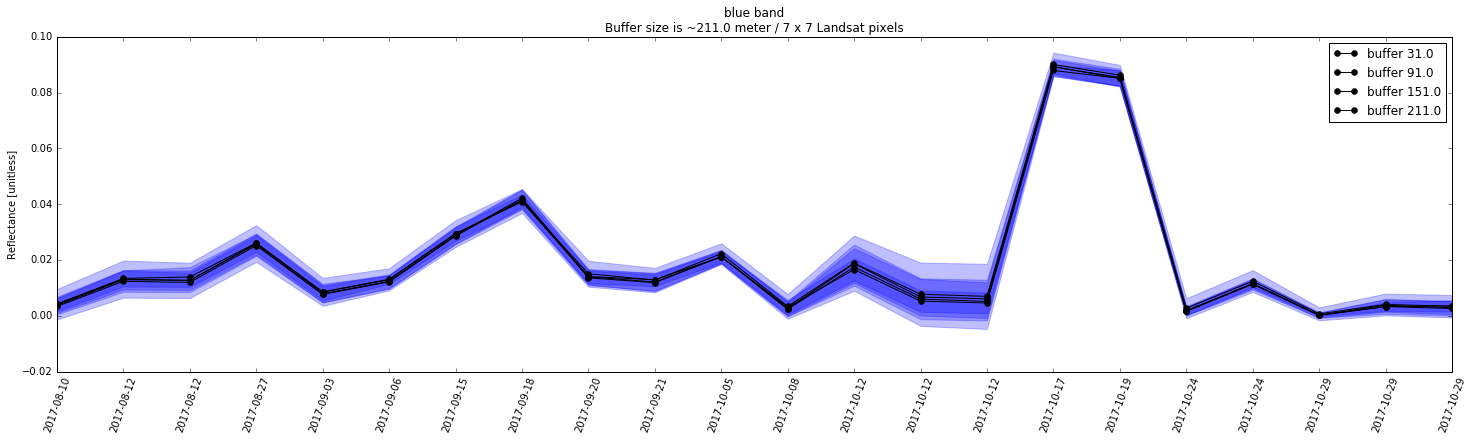

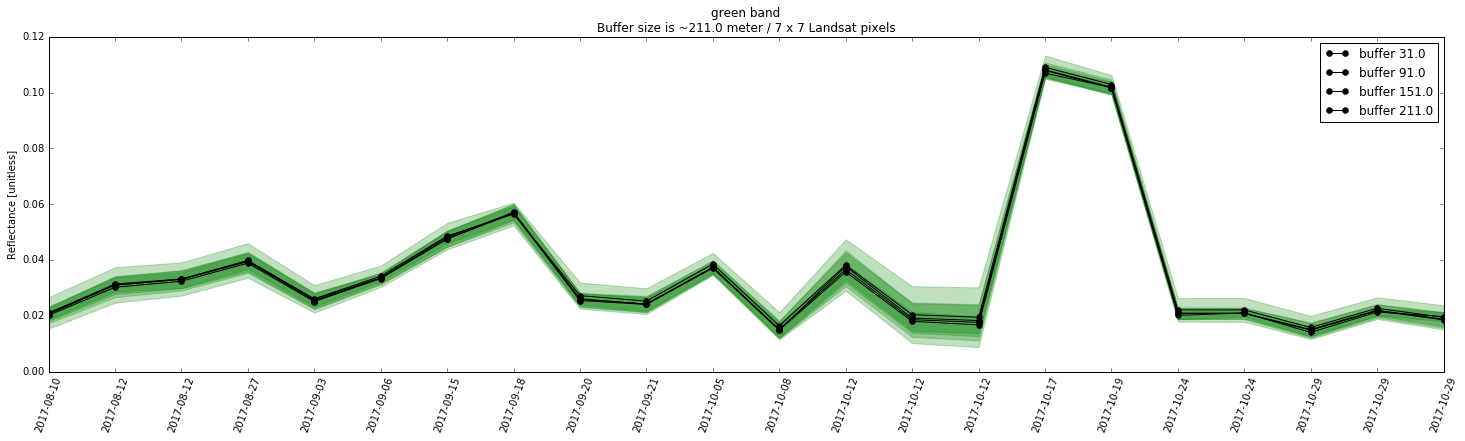

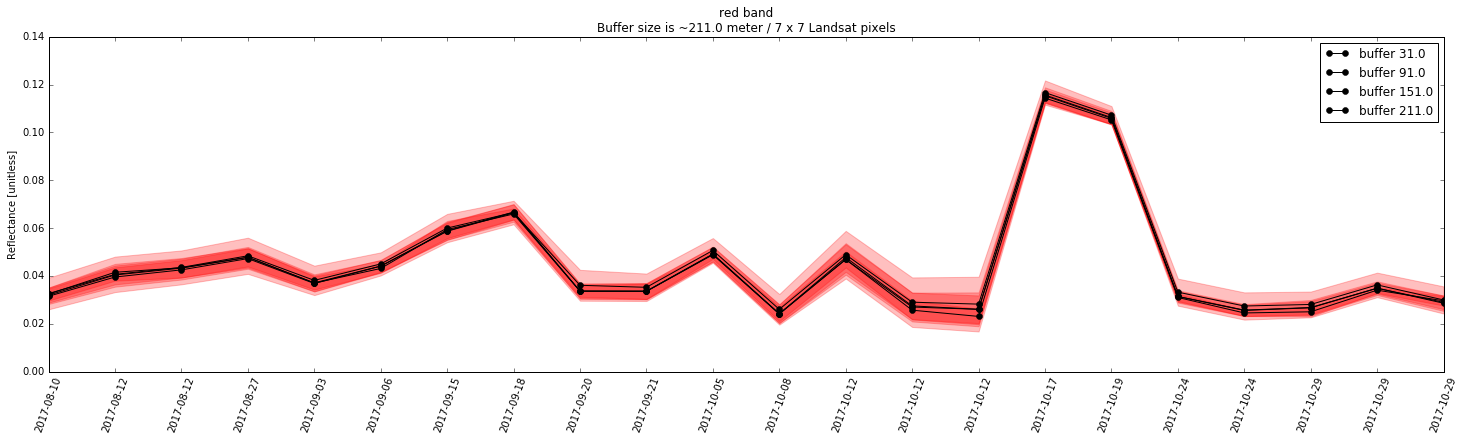

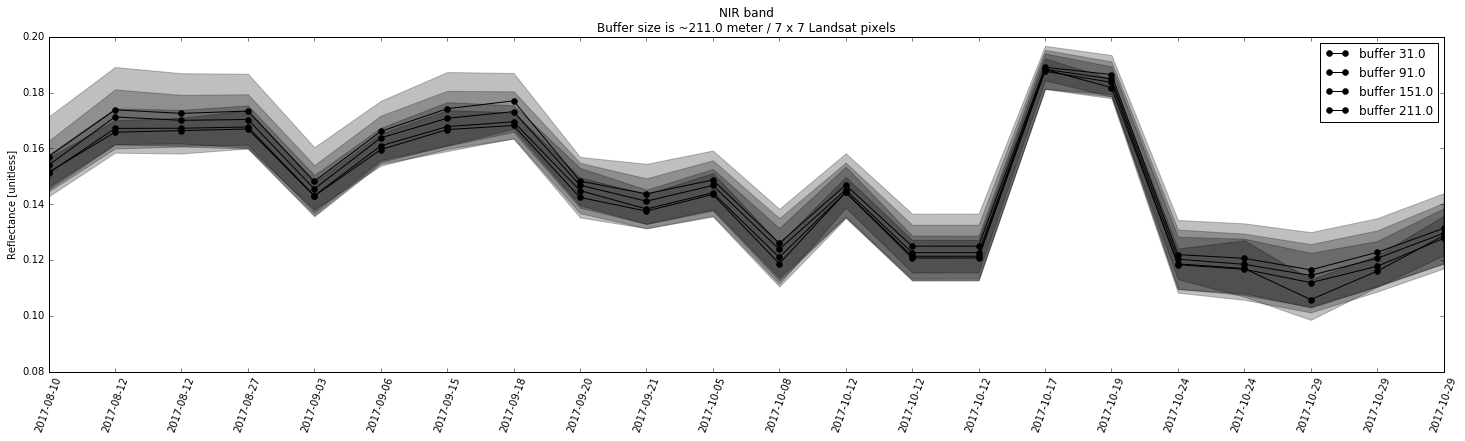

**************************************************************************
**************************************************************************
****************** PLOT 2 ***********************************************
**************************************************************************


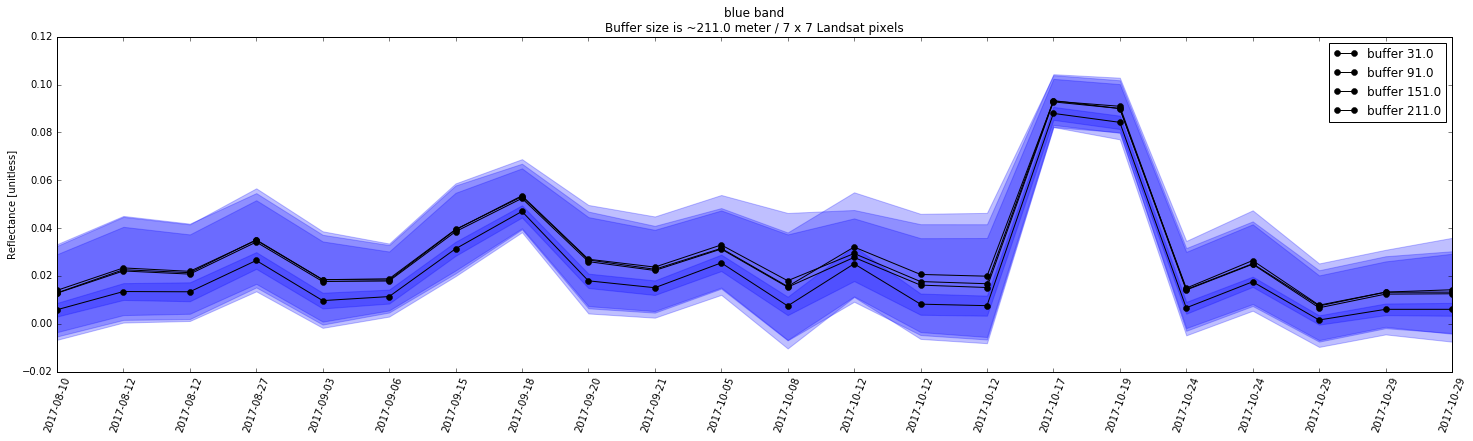

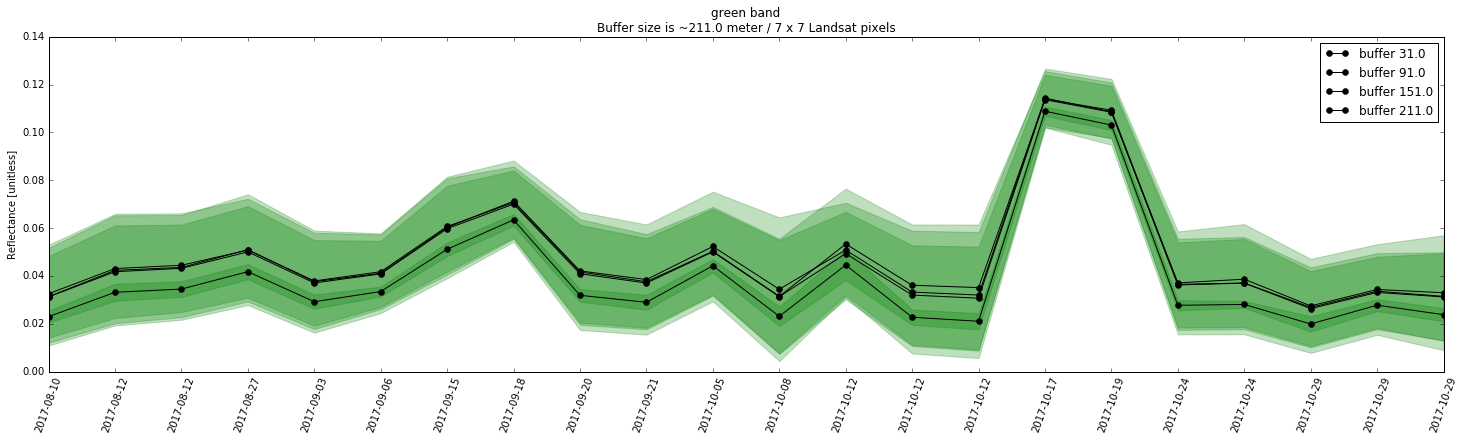

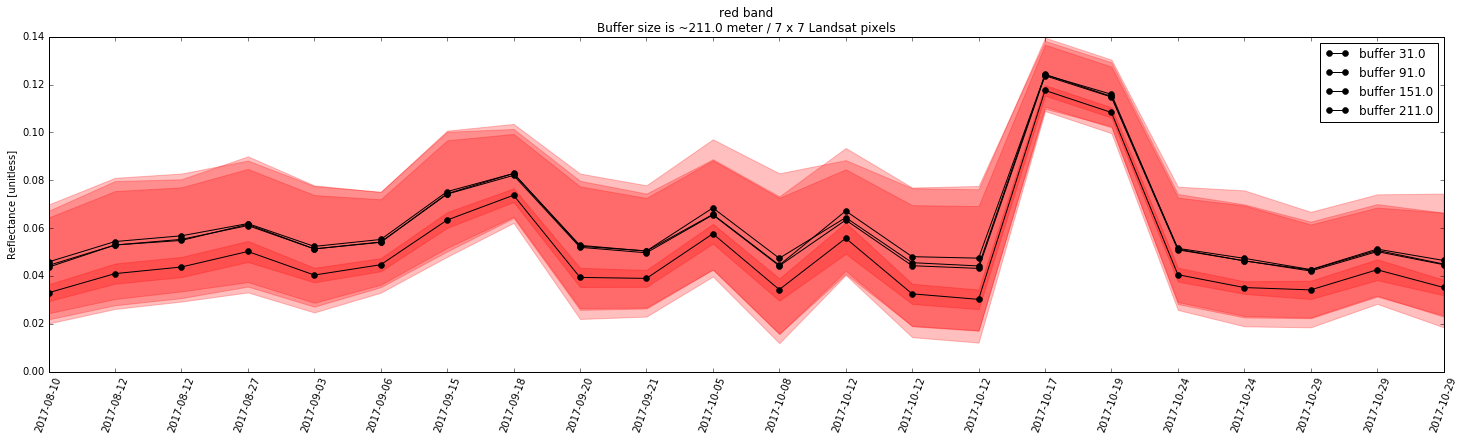

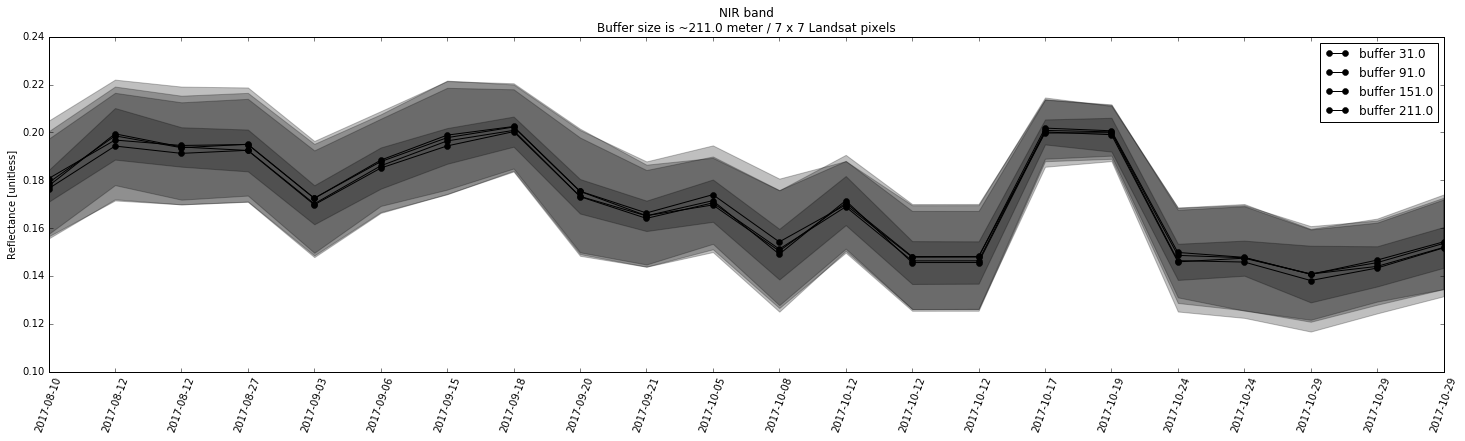

**************************************************************************
**************************************************************************
****************** PLOT 3 ***********************************************
**************************************************************************


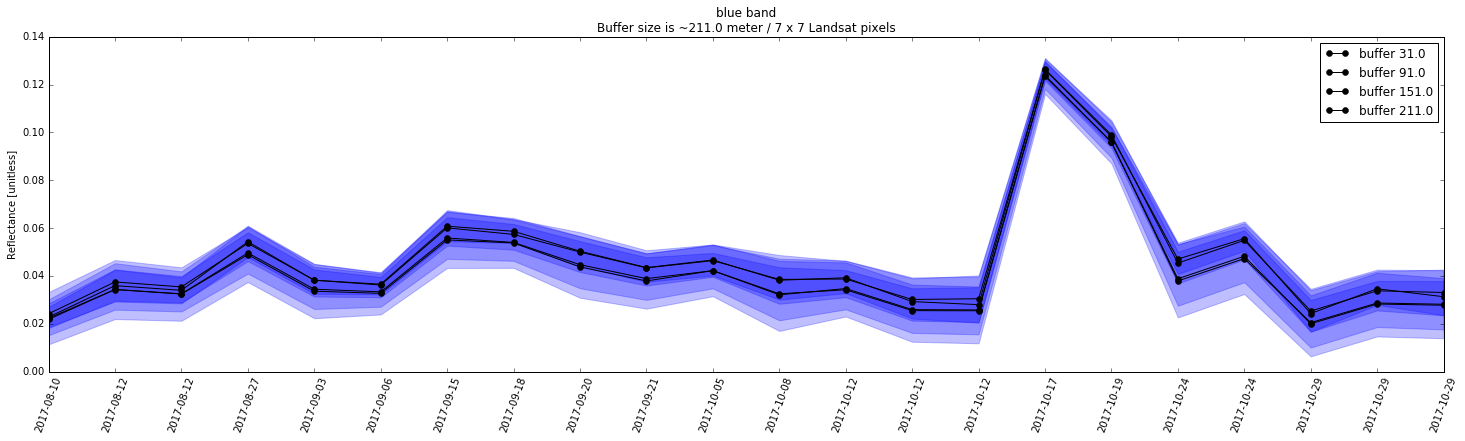

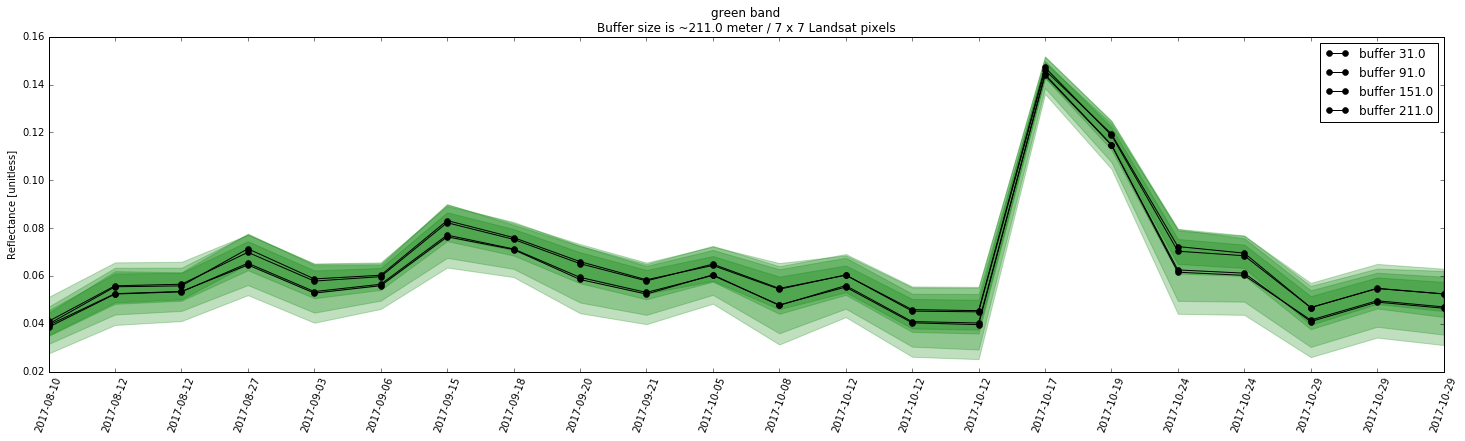

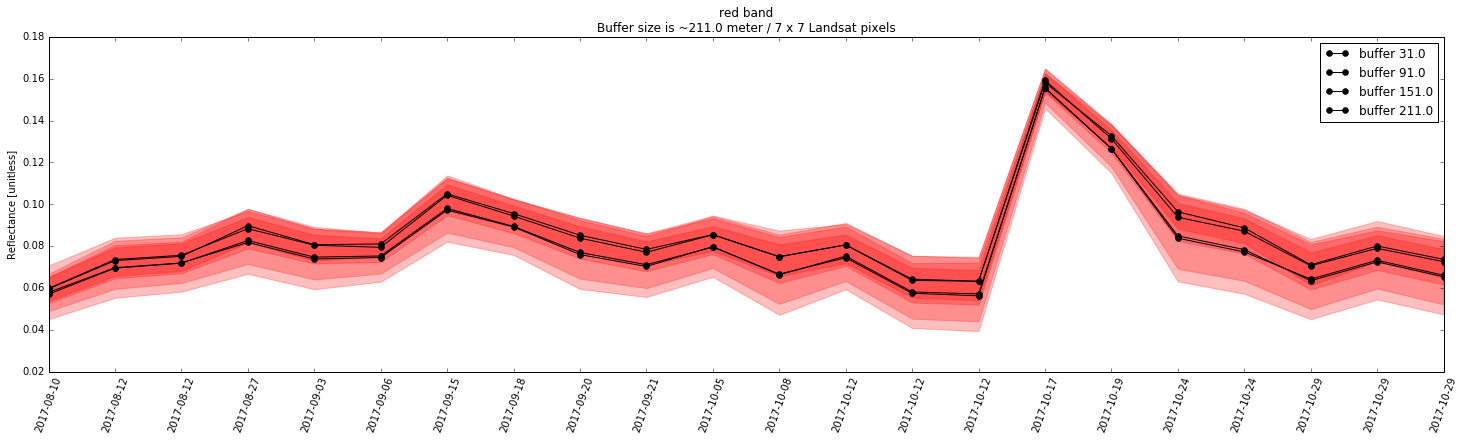

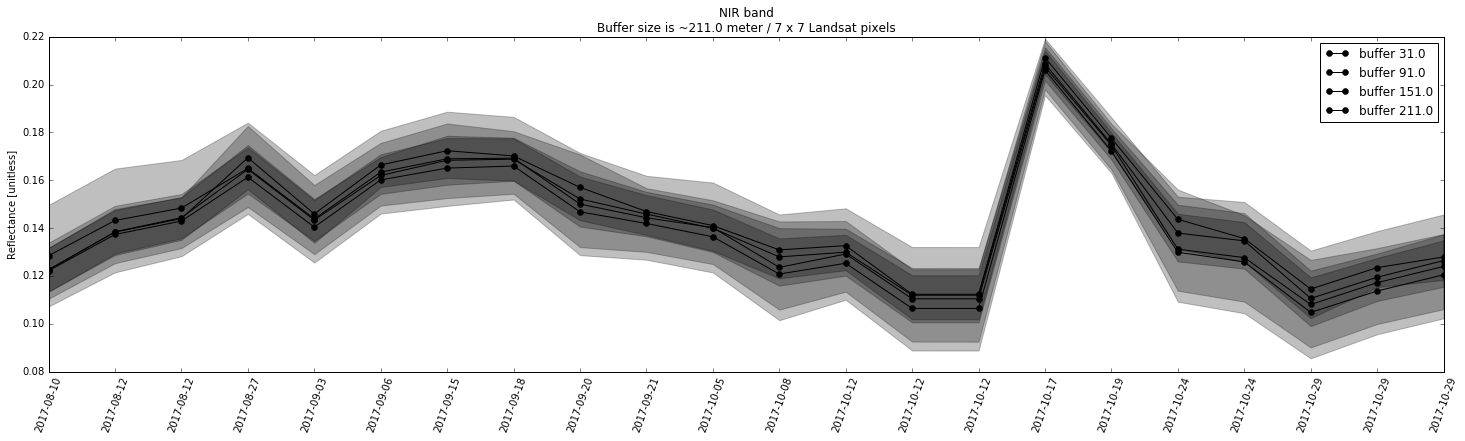

**************************************************************************
**************************************************************************
****************** PLOT 4 ***********************************************
**************************************************************************


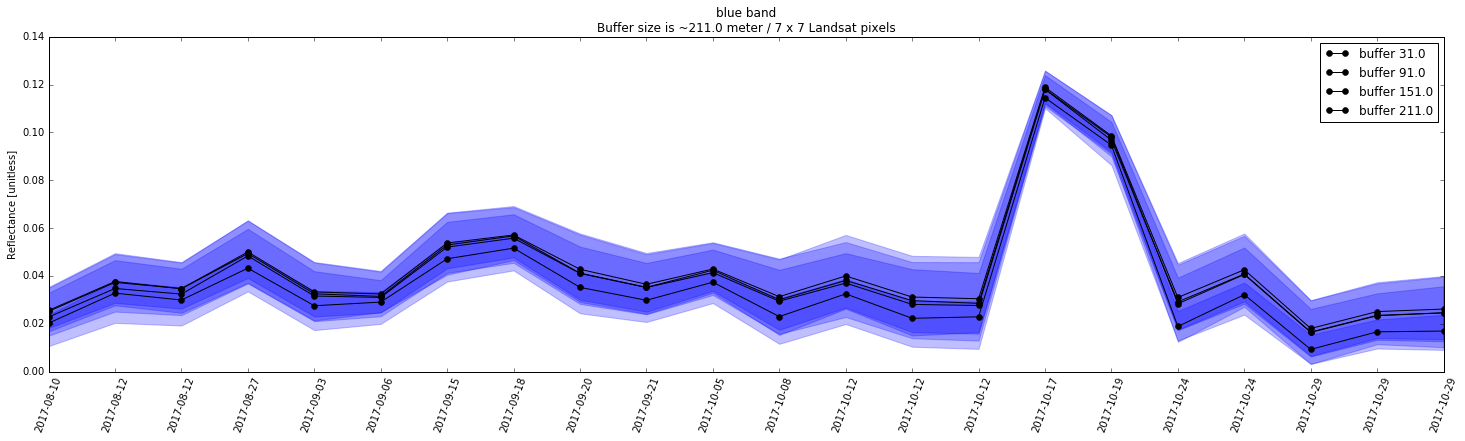

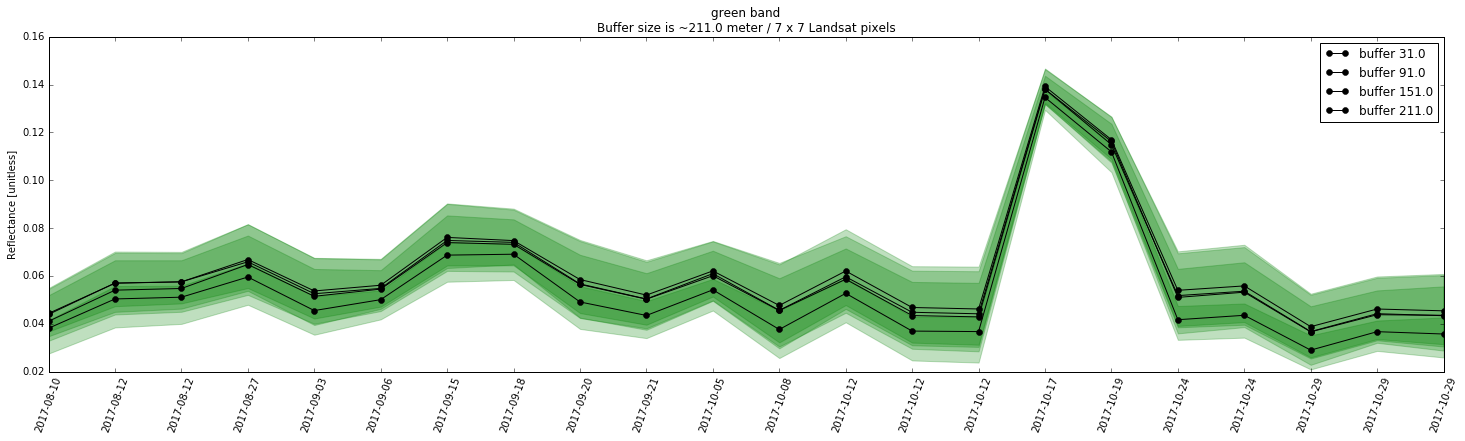

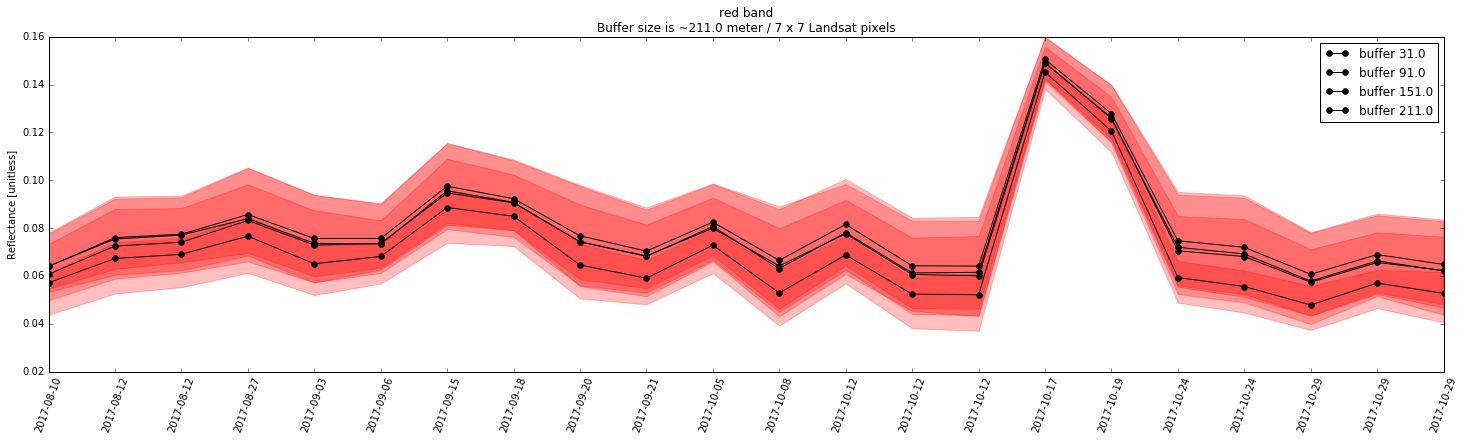

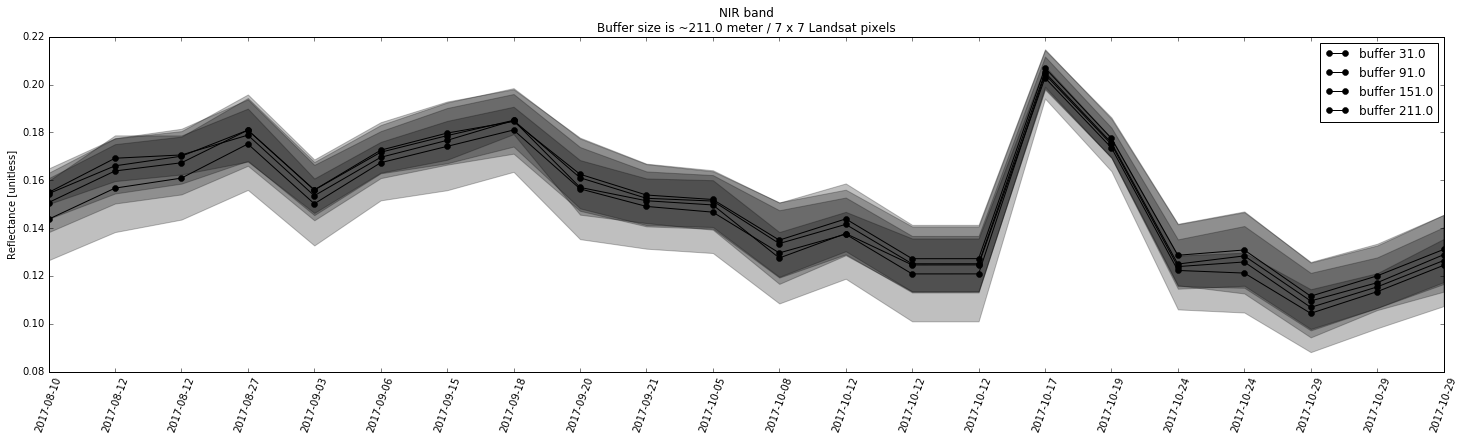

**************************************************************************
**************************************************************************
****************** PLOT 5 ***********************************************
**************************************************************************


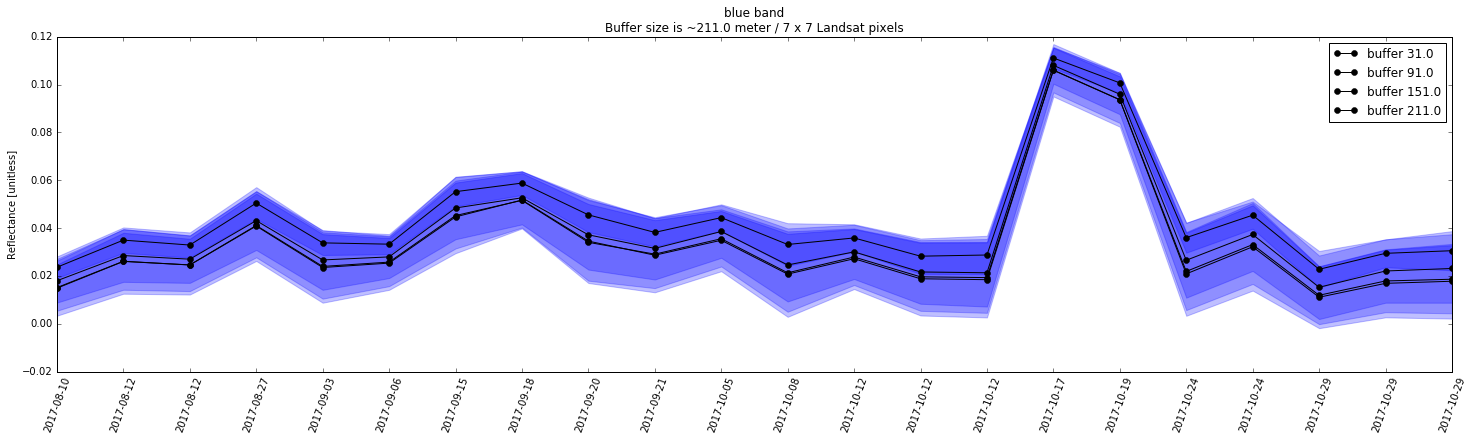

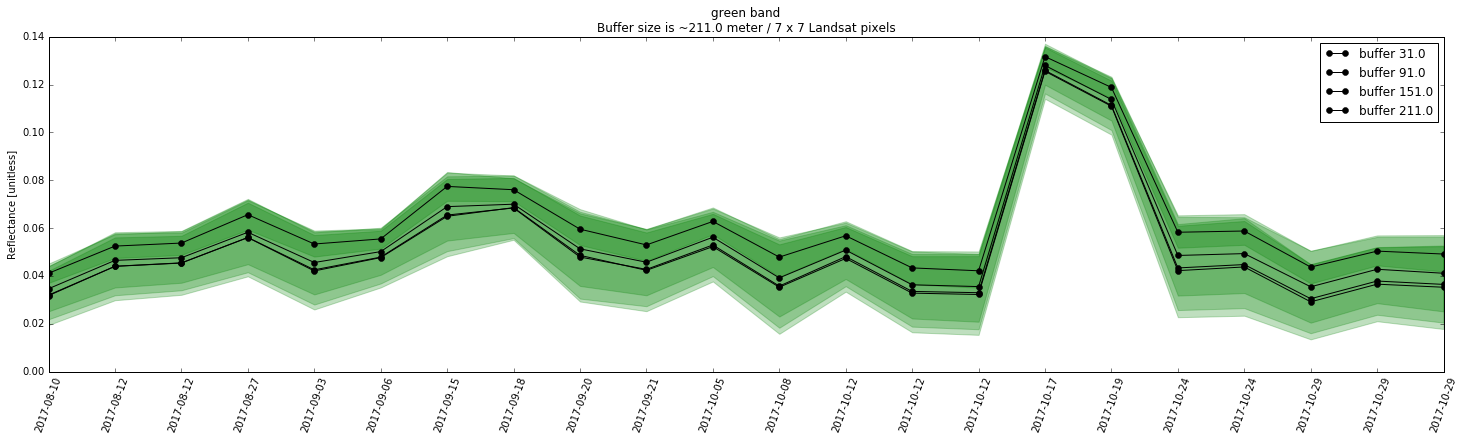

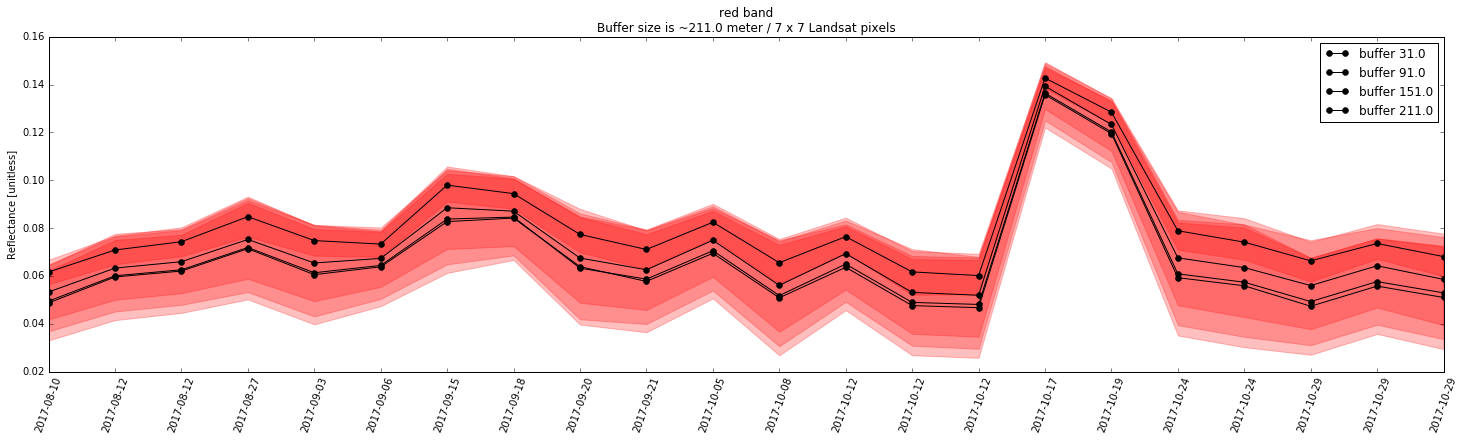

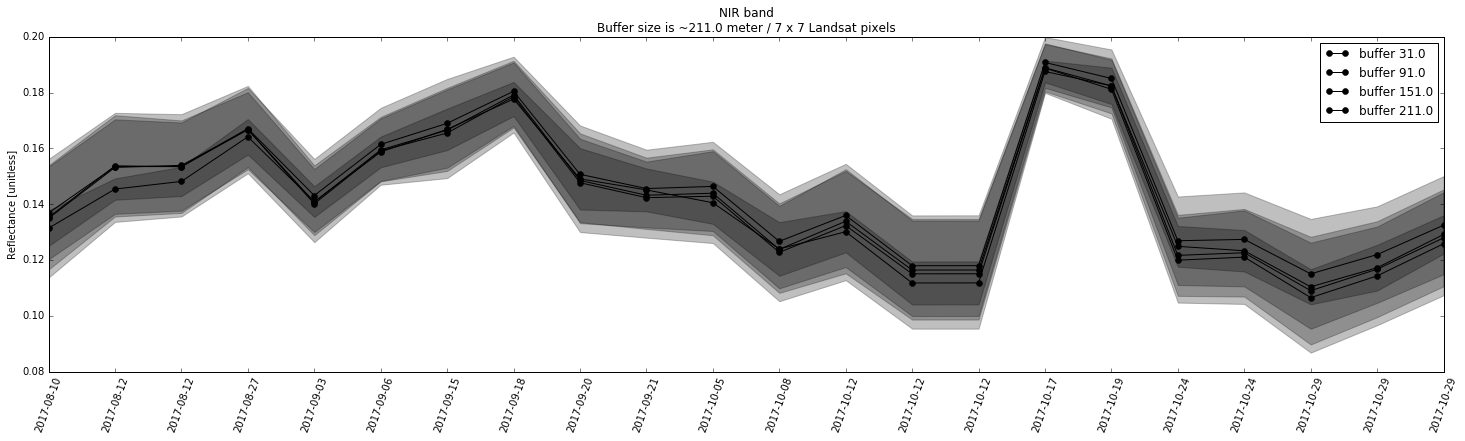

**************************************************************************
**************************************************************************
****************** PLOT 6 ***********************************************
**************************************************************************


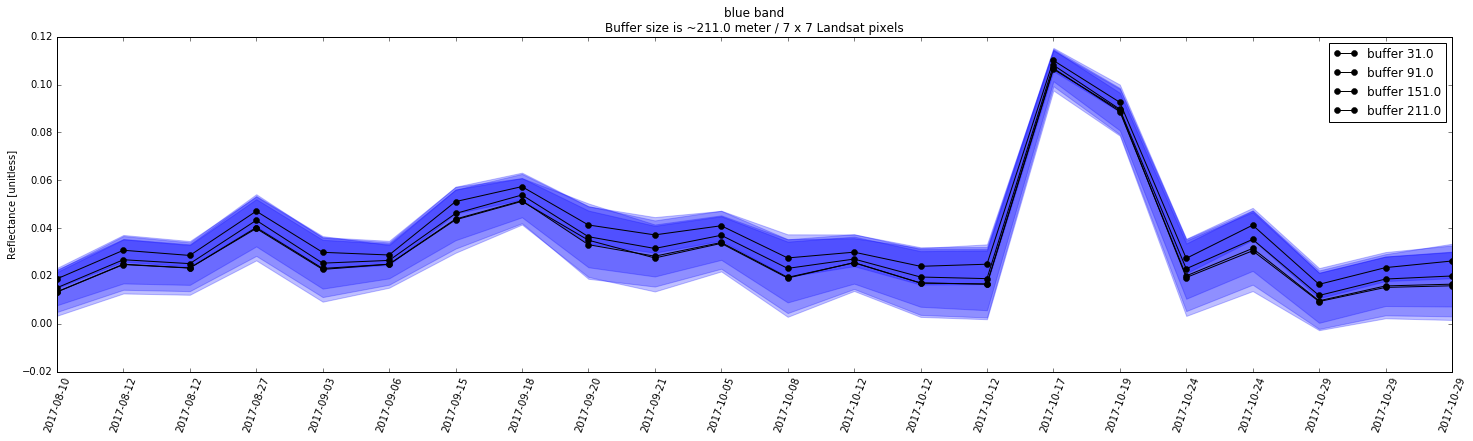

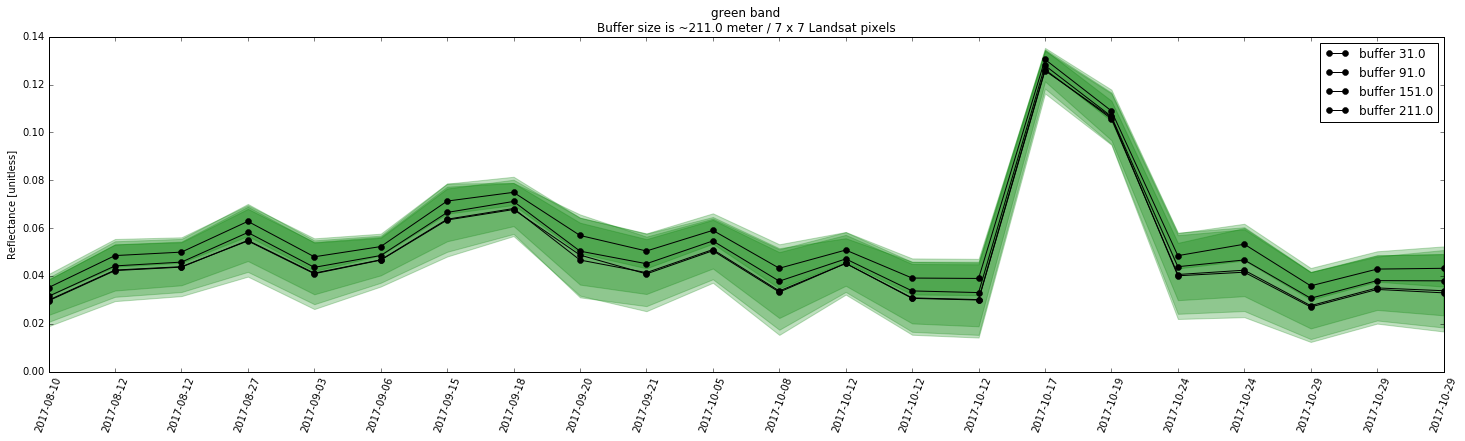

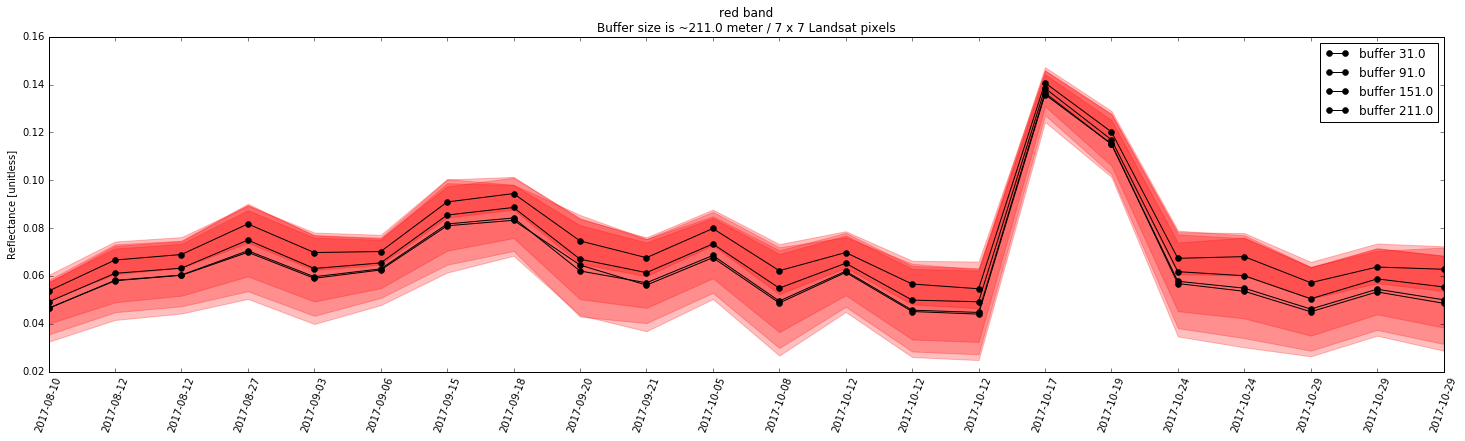

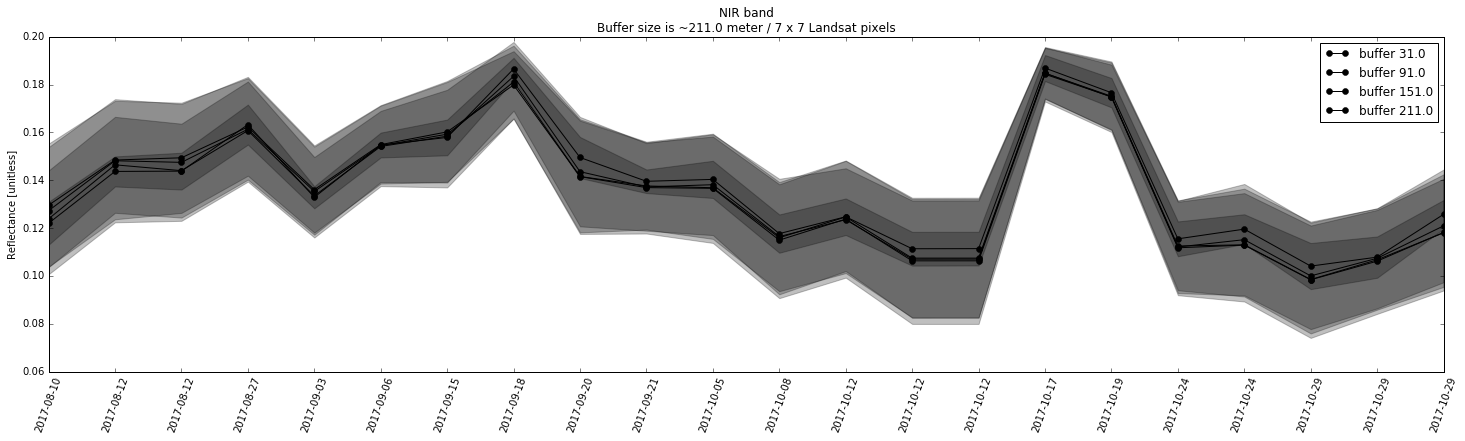

**************************************************************************


In [151]:
def get_std_list(a):
    
    if type(a) == np.int:
        return [0,0,0,0]
            
    else:
        nbands = a.shape[0]
        return [np.std(b[b>0]/10000.) for b in a]
        
def get_mean_list(a):
    
    if type(a) == np.int:
        return [0,0,0,0]
            
    else:
        nbands = a.shape[0]
        return [np.mean(b[b>0]/10000.) for b in a]
    
    
    

buf_sizes = [31, 91, 151, 211]
buf_sizes = [float(i)/2 for i in buf_sizes]

# centroids = [shape(p).centroid for p in polys]
# buffer_p = [c.buffer(buffer_distance, cap_style=3) for c in centroids]

# # convert them back to geojson
# buffers = [mapping(b) for b in buffer_p]

bands=['blue', 'green', 'red', 'NIR']
colors = ['b', 'g', 'r', 'k']
plot_ind = 0
check_means, check_std, inds, dates = [], [], [], []
band = 2

for plot_ind in range(7):
    print('**************************************************************************')
    print('****************** PLOT {} ***********************************************'.format(plot_ind))
    print('**************************************************************************')
    
    for band in range(len(bands)):
        plt.figure(figsize=(25,6))

        for buf in buf_sizes:
            #plot_fi = os.path.join(fig_dir, 'planet_landsat_compare_buffer_{}_m.png'.format(buf))

            # buffer out. square capping.
            buffer_p = [c.buffer(buf, cap_style=3) for c in centroids]

            # convert them back to geojson
            buffers = [mapping(b) for b in buffer_p]

            #pl_res = [meanIntensityOverGeometry(home_dir, poly) for poly in buffers]
            pl_res = meanIntensityOverGeometry(home_dir, buffers[plot_ind])

            # get the standard deviation and means of the image patch
            stds = [get_std_list(arr) for arr in pl_res['sr_image']]
            means = [get_mean_list(arr) for arr in pl_res['sr_image']]


            # make into a numpy array (shape n_obs x 4 (bands))
            a_std   = np.array(stds)
            a_means = np.array(means)       


            # valid dates (nonzero measurements) THIS CHANGES WITH BUFFER SIZE, potentially. use the first one.
            bad_inds = np.where(a_means.std(axis=1) == 0)[0]
            inds.append(bad_inds)        
            bad_inds = inds[0]

            a_means  = np.delete(a_means, bad_inds, axis=0)
            a_std    = np.delete(a_std, bad_inds, axis=0)

            dates.append(pl_res['dates'])
            plot_dates = dates[0]

            check_means.append(a_means)
            check_std.append(a_std)

            #plt.figure(figsize=(25,6))

            ax = plt.gca()
            #xmarks = range(0, len(pl_res['dates'])+1, 1)
            xmarks = range(0, len(plot_dates)+1, 1)
            plt.xticks(xmarks)

            #ax.set_xticklabels(pl_res['dates'])
            ax.set_xticklabels(plot_dates)
            plt.xticks(rotation=70)
            ax.grid()

            x = np.arange(a_means.shape[0])
            x = np.arange(len(pl_res['dates']))
            x = np.arange(len(plot_dates))
            y = a_means[:, band]
            err = a_std[:, band]

            plt.plot(x, y, 'ko-', label='buffer {}'.format(buf*2))
            plt.fill_between(x, y - err, y + err, alpha=0.25, color=colors[band])

        plt.title('{0} band\nBuffer size is ~{1} meter / {2} x {2} Landsat pixels'.format(bands[band],buf*2, int(buf*2/30)))
        plt.ylabel('Reflectance [unitless]')

        plt.legend()
        plt.show()

    print('**************************************************************************')
        
        


### this plotting cell plot each buffer size separately for a single band.

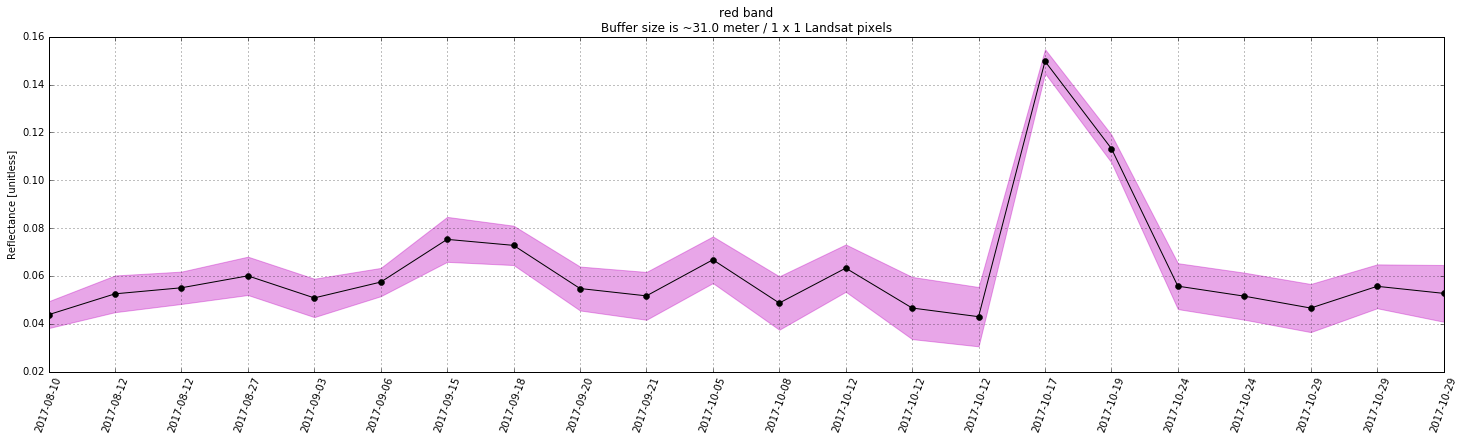

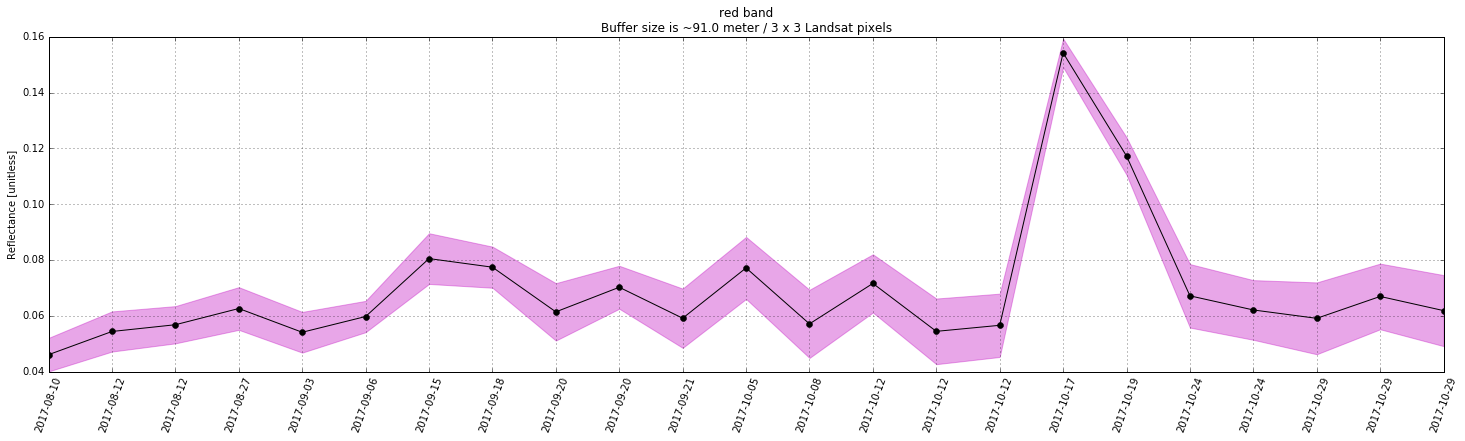

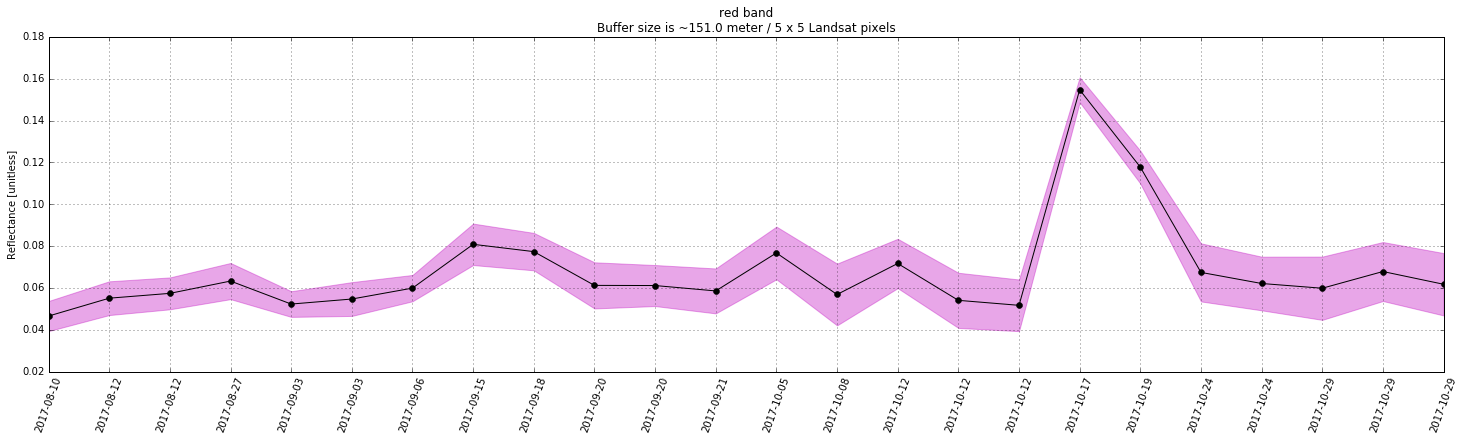

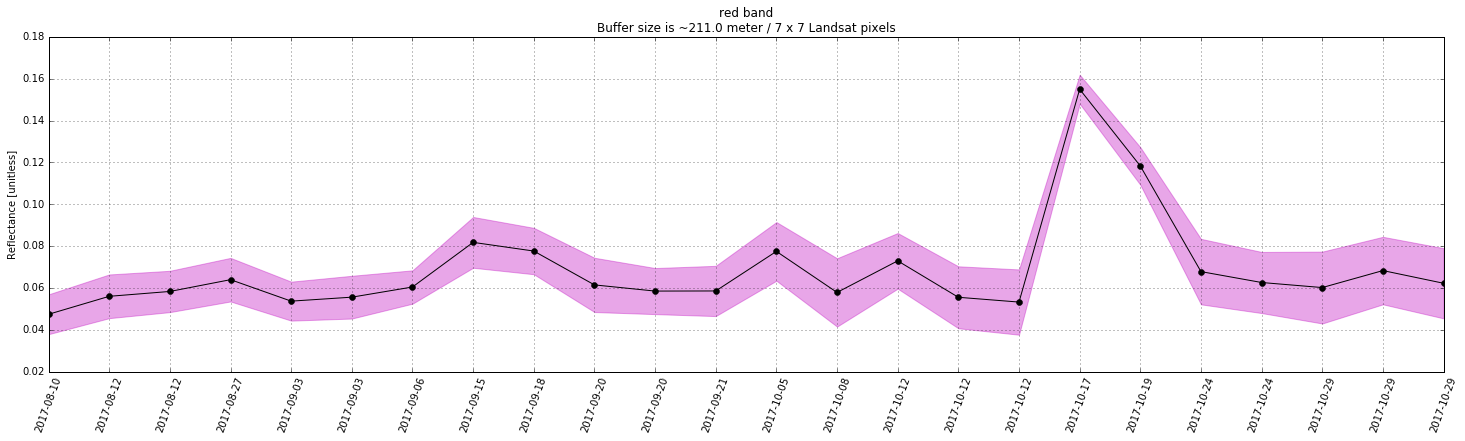

In [153]:
def get_std_list(a):
    
    if type(a) == np.int:
        return [0,0,0,0]
            
    else:
        nbands = a.shape[0]
        return [np.std(b[b>0]/10000.) for b in a]
        
def get_mean_list(a):
    
    if type(a) == np.int:
        return [0,0,0,0]
            
    else:
        nbands = a.shape[0]
        return [np.mean(b[b>0]/10000.) for b in a]
    
    
    

buf_sizes = [31, 91, 151, 211]
buf_sizes = [float(i)/2 for i in buf_sizes]

# centroids = [shape(p).centroid for p in polys]
# buffer_p = [c.buffer(buffer_distance, cap_style=3) for c in centroids]

# # convert them back to geojson
# buffers = [mapping(b) for b in buffer_p]

bands=['blue', 'green', 'red', 'NIR']
colors = ['b', 'g', 'r', 'k']
plot_ind = 0
check_means, check_std, inds, dates = [], [], [], []
band = 2

for buf in buf_sizes:
        #plot_fi = os.path.join(fig_dir, 'planet_landsat_compare_buffer_{}_m.png'.format(buf))

        # buffer out. square capping.
        buffer_p = [c.buffer(buf, cap_style=3) for c in centroids]

        # convert them back to geojson
        buffers = [mapping(b) for b in buffer_p]
        
        #pl_res = [meanIntensityOverGeometry(home_dir, poly) for poly in buffers]
        pl_res = meanIntensityOverGeometry(home_dir, buffers[plot_ind])
                
        # get the standard deviation and means of the image patch
        stds = [get_std_list(arr) for arr in pl_res['sr_image']]
        means = [get_mean_list(arr) for arr in pl_res['sr_image']]
        
        
        # make into a numpy array (shape n_obs x 4 (bands))
        a_std   = np.array(stds)
        a_means = np.array(means)       
        
        
        # valid dates (nonzero measurements) THIS CHANGES WITH BUFFER SIZE, potentially. use the first one.
        bad_inds = np.where(a_means.std(axis=1) == 0)[0]
       
        a_means  = np.delete(a_means, bad_inds, axis=0)
        a_std    = np.delete(a_std, bad_inds, axis=0)

        
        check_means.append(a_means)
        check_std.append(a_std)
        
        plt.figure(figsize=(25,6))
        plt.legend()
        ax = plt.gca()
        xmarks = range(0, len(pl_res['dates'])+1, 1)
        plt.xticks(xmarks)

        ax.set_xticklabels(pl_res['dates'])
        plt.xticks(rotation=70)
        ax.grid()

        x = np.arange(a_means.shape[0])
        x = np.arange(len(pl_res['dates']))
        y = a_means[:, band]
        
        err = a_std[:, band]
        plt.plot(x, y, 'ko-', label='PlanetScope')
        plt.fill_between(x, y - err, y + err, alpha=0.35, color='m')
        
        plt.title('{0} band\nBuffer size is ~{1} meter / {2} x {2} Landsat pixels'.format(bands[band],buf*2, int(buf*2/30)))
        plt.ylabel('Reflectance [unitless]')


        plt.show()
        
